# Figure X. Batch Size

Imports.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

Load from disk.

In [586]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            result = json.load(text_file)
                            record = pd.DataFrame(
                                result['annotations']
                            ).reindex(
                                columns=[
                                    'ABL1 pIC50',
                                    'Log P',
                                    'Log S',
                                    'Step Made',
                                    'Step Scored',
                                ]
                            ).dropna(subset='Step Scored')

                            value = result[measure]
                            trial_indices[value] += 1
                            record[measure] = value
                            record['trial'] = trial_indices[value]
                            
                            records.append(record)
                            result = None
                        except:
                            continue
    return records

paths = [
    '../../dgym-data/analysis/batch_size/selection_score_ratio_2024-05-15_00-09-21.zip',
]

measure = 'score_ratio'
records = []
for path in paths:
    records.extend(get_records(path, measure))

df_raw = pd.concat(records)
records = None

  0%|          | 0/345 [00:00<?, ?it/s]

Score using utility function.

In [587]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction([
    docking_utility_function, log_P_utility_function, log_S_utility_function])

In [696]:
records = []
for (value, trial), data in tqdm(df_raw.groupby([measure, 'trial'])):
    utility = composite_utility_function(data.values, precompute=True, method='average')
    try:
        completion_idx = utility.index(1.0)
        success = 1
    except:
        completion_idx = len(utility)
        success = 0
    
    # find number made and scored
    data_to_completion = data.iloc[:completion_idx+1]
    num_made = len(data_to_completion.dropna(subset='Step Made'))
    num_scored = len(data_to_completion.dropna(subset='Step Scored'))
    score_ratio = num_scored / num_made
    
    record = {
        measure: value,
        'empirical_score_ratio': score_ratio,
        'trial': trial,
        'outcome': success,
        'number_made': num_made,
        'number_scored': num_scored,
        'time': data['Step Made'].max()
    }
    records.append(record)

df = pd.DataFrame(records)

  0%|          | 0/324 [00:00<?, ?it/s]

Plotting adjusted outcomes.

In [697]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
def get_ecdf(budget_type):
    
    max_cost = df[budget_type].max()
    timeline = np.linspace(0, max_cost, 500)

    ecdfs = []
    for idx, (value, group) \
        in enumerate(df.groupby(measure)):

        # Create Kaplan-Meier object
        kmf = KaplanMeierFitter()

        # Fit data
        kmf.fit(
            durations=group[budget_type],
            event_observed=group['outcome'],
            timeline=timeline,
            alpha=0.32
        )

        # add confidence intervals
        ecdf_ = pd.merge(
            kmf.cumulative_density_,
            right=kmf.confidence_interval_cumulative_density_,
            left_index=True,
            right_index=True
        ).reset_index()

        ecdf_[measure] = value
        ecdfs.append(ecdf_)

    ecdf = pd.concat(ecdfs)
    
    return ecdf

budget = 'number_made'
ecdf = get_ecdf(budget)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

(-0.05, 1.05)

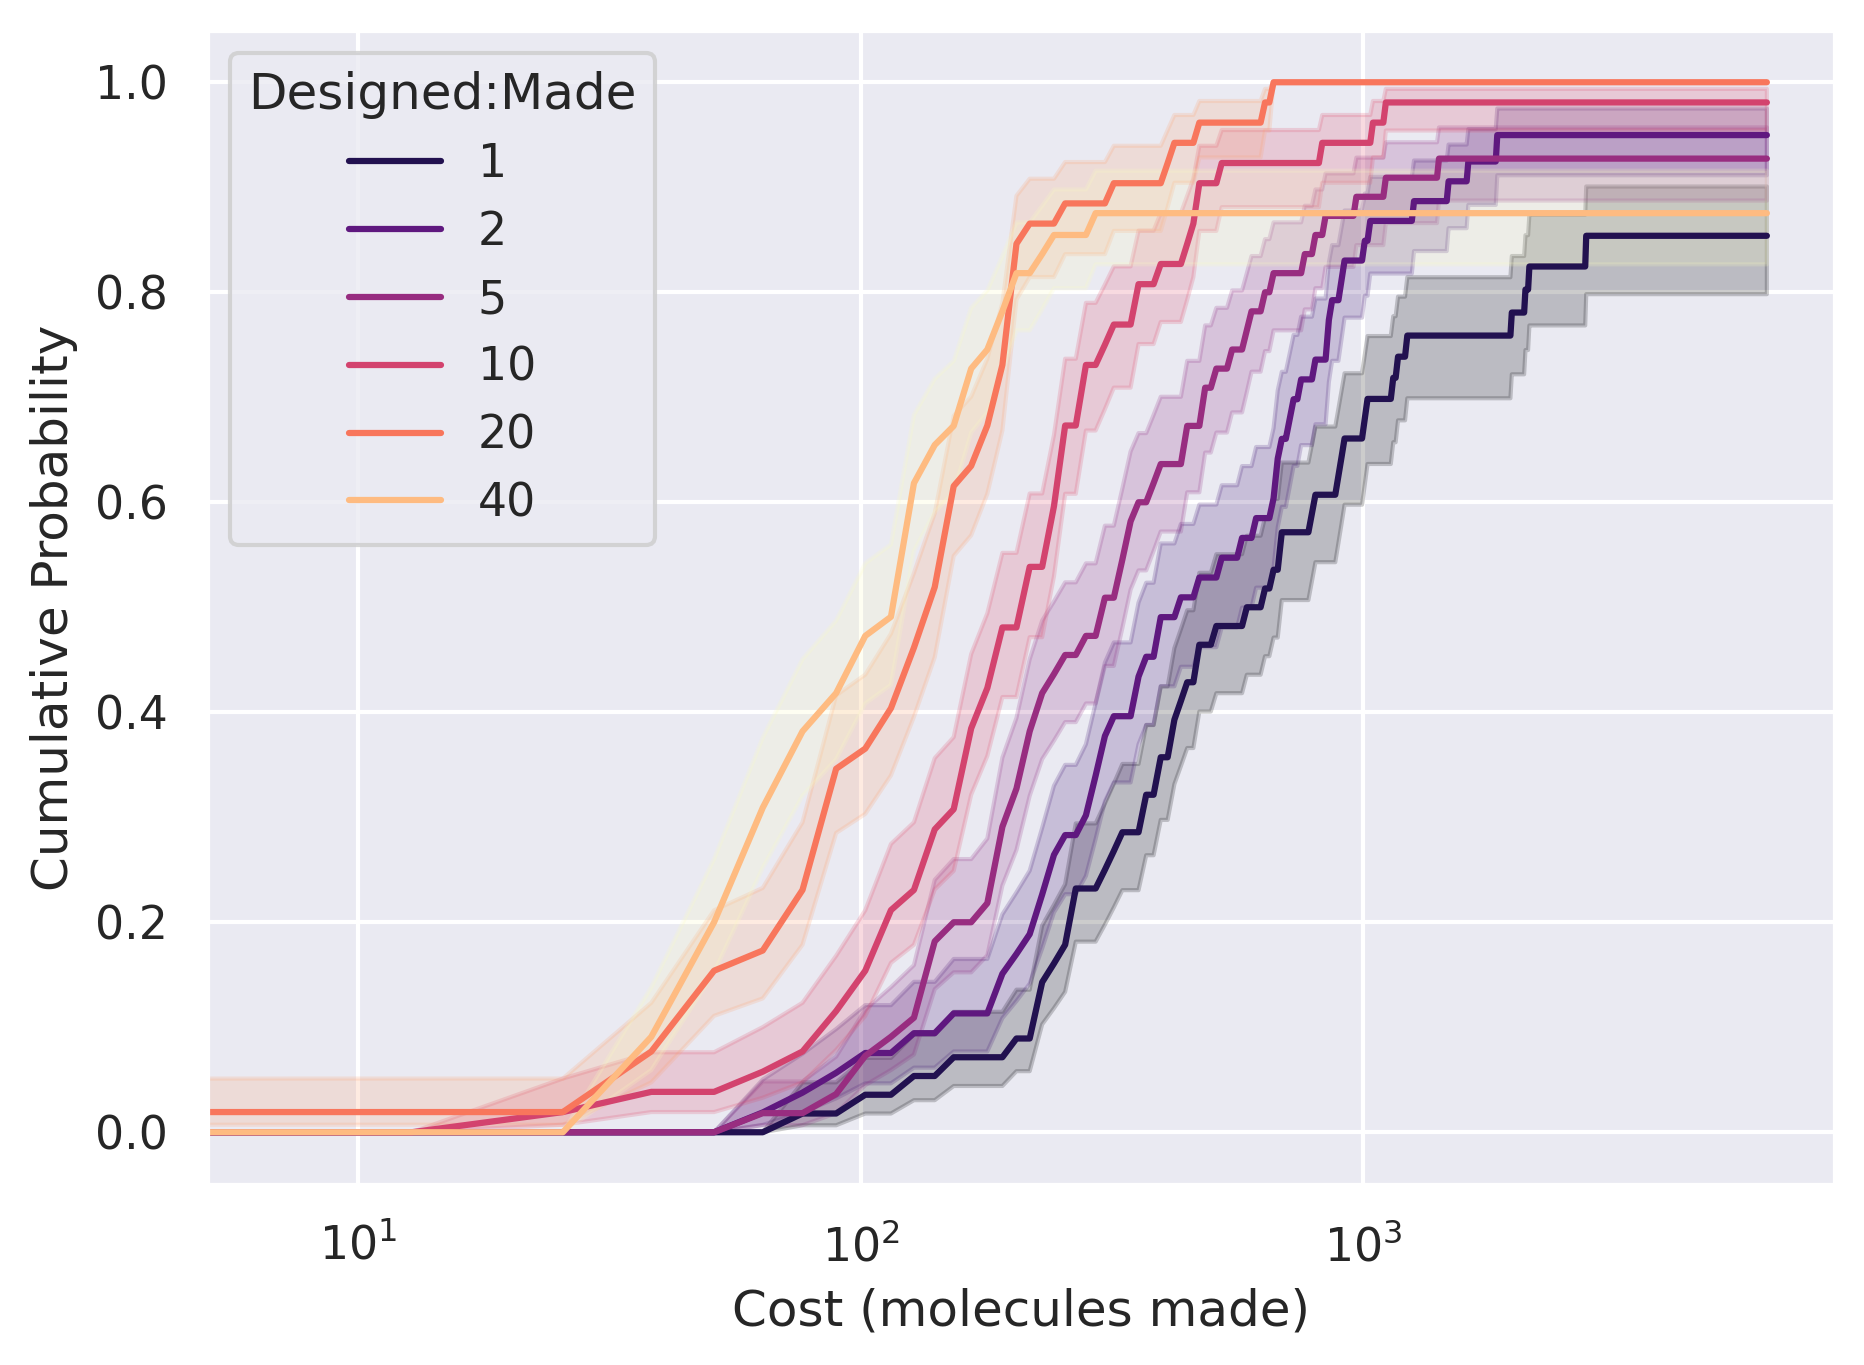

In [698]:
import seaborn as sns

plt.figure(figsize=(7, 5), dpi=300)

sns.set()
g = sns.lineplot(
    ecdf,
    x='timeline',
    y='KM_estimate',
    hue=measure,
    palette=sns.color_palette('magma', len(ecdf[measure].unique()))
)

colormap = sns.palettes.get_colormap('magma')
colors = colormap.resampled(len(ecdf.groupby(measure)))

for idx, (name, group) in enumerate(ecdf.groupby(measure)):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.2,
        color=colors.colors[idx]
    )

plt.legend(title='Designed:Made')
plt.xlabel('Cost (molecules made)')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.xlim(5)
plt.ylim(-0.05, 1.05)
# plt.title('Cumulative probability of success versus ratio designed:made')

### Plot variable vs. outcome

In [699]:
def closest_budgets(df, target_budgets, budget_var, measure_var):
    """
    Filters the DataFrame to get the budgets that are closest to the target budgets within each setting of 'variable'.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least two columns: 'budget' and 'variable'.
    target_budgets : list of float
        List of target budgets to compare against.
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the rows with budgets closest to the target budgets within each setting of 'variable'.
    """
    def find_and_replace(df_group, targets):
        closest_rows = []
        for target in targets:
            # Filter for budgets that are less than or equal to the target budget
            filtered_df = df_group[df_group[budget_var] <= target]
            if not filtered_df.empty:
                # Find the closest budget less than or equal to the target budget
                closest_row = filtered_df.loc[(filtered_df[budget_var] - target).abs().idxmin()]
                closest_row[budget_var] = target
                closest_rows.append(closest_row)
        return pd.DataFrame(closest_rows)

    return df.groupby(measure_var).apply(find_and_replace, targets=target_budgets).reset_index(drop=True)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0, 0.5, 'Success rate')

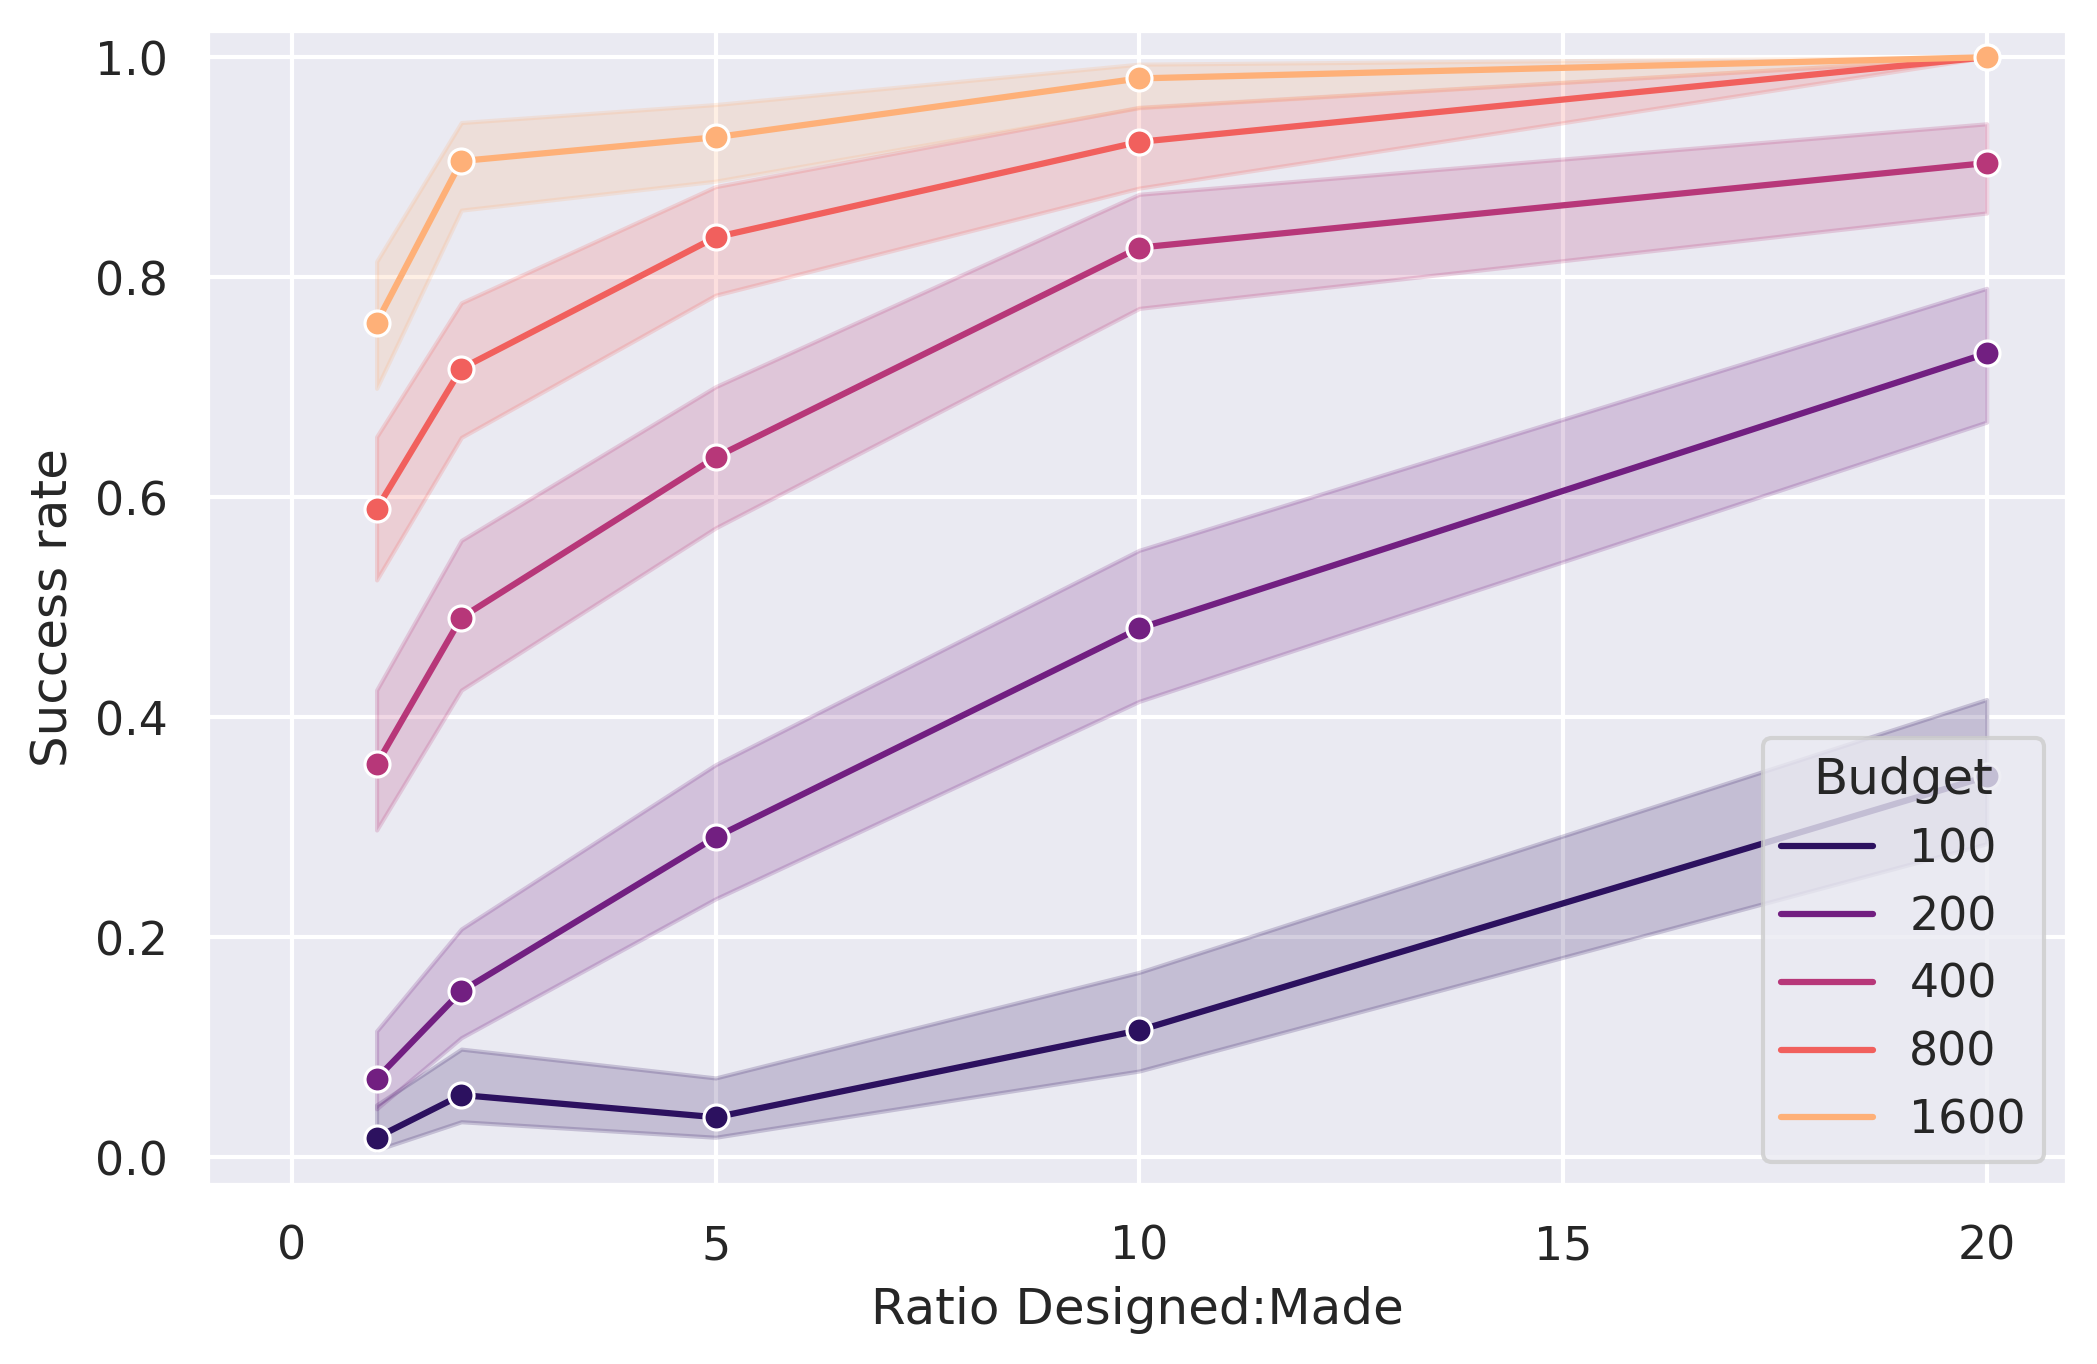

In [700]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

subset = ecdf.query('score_ratio not in [40]')
budget_sigma = closest_budgets(subset, [100, 200, 400, 800, 1600], 'timeline', 'score_ratio')
budget_sigma = budget_sigma.rename(columns={'timeline': 'Budget'})
budget_sigma['Budget'] = budget_sigma['Budget'].astype(int)

g = sns.lineplot(
    budget_sigma,
    x=measure,
    y='KM_estimate',
    hue='Budget',
    marker='o',
    ci=False,
    palette=sns.color_palette('magma', len(budget_sigma['Budget'].unique())),
    ax=ax
)

colors = sns.color_palette('magma', len(budget_sigma['Budget'].unique()))
for idx, (name, group) in enumerate(budget_sigma.groupby('Budget')):
    g.fill_between(
        group[measure],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.2,
        color=colors[idx],
    )

plt.ylim(-0.025, 1.025)
plt.xticks([0, 5, 10, 15, 20])
plt.xlim(-1) # , 25.025)
plt.xlabel('Ratio Designed:Made')
plt.ylabel(f'Success rate')
# plt.title(f'Success rate versus ratio designed:made under fixed budgets')

## Minimum expected costs to achieve probability of success

In [701]:
def closest_success_rate(df, target_success_rates, success_rate_var, measure_var):
    """
    Filters the DataFrame to get the budgets that are closest to the target budgets within each setting of 'variable'.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least two columns: 'budget' and 'variable'.
    target_budgets : list of float
        List of target budgets to compare against.
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the rows with budgets closest to the target budgets within each setting of 'variable'.
    """
    def find_and_replace(df_group, targets):
        closest_rows = []
        for target in targets:
            # Filter for success rates that are at least the target success rate
            filtered_df = df_group # [df_group[success_rate_var] >= target]
            if not filtered_df.empty:
                # Find the closest budget less than or equal to the target budget
                closest_row = filtered_df.loc[(filtered_df[success_rate_var] - target).abs().idxmin()]
                closest_row['Success Rate'] = target
                closest_rows.append(closest_row)
        return pd.DataFrame(closest_rows)

    return df.groupby(measure_var).apply(find_and_replace, targets=target_success_rates).reset_index(drop=True)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0, 0.5, 'Cost')

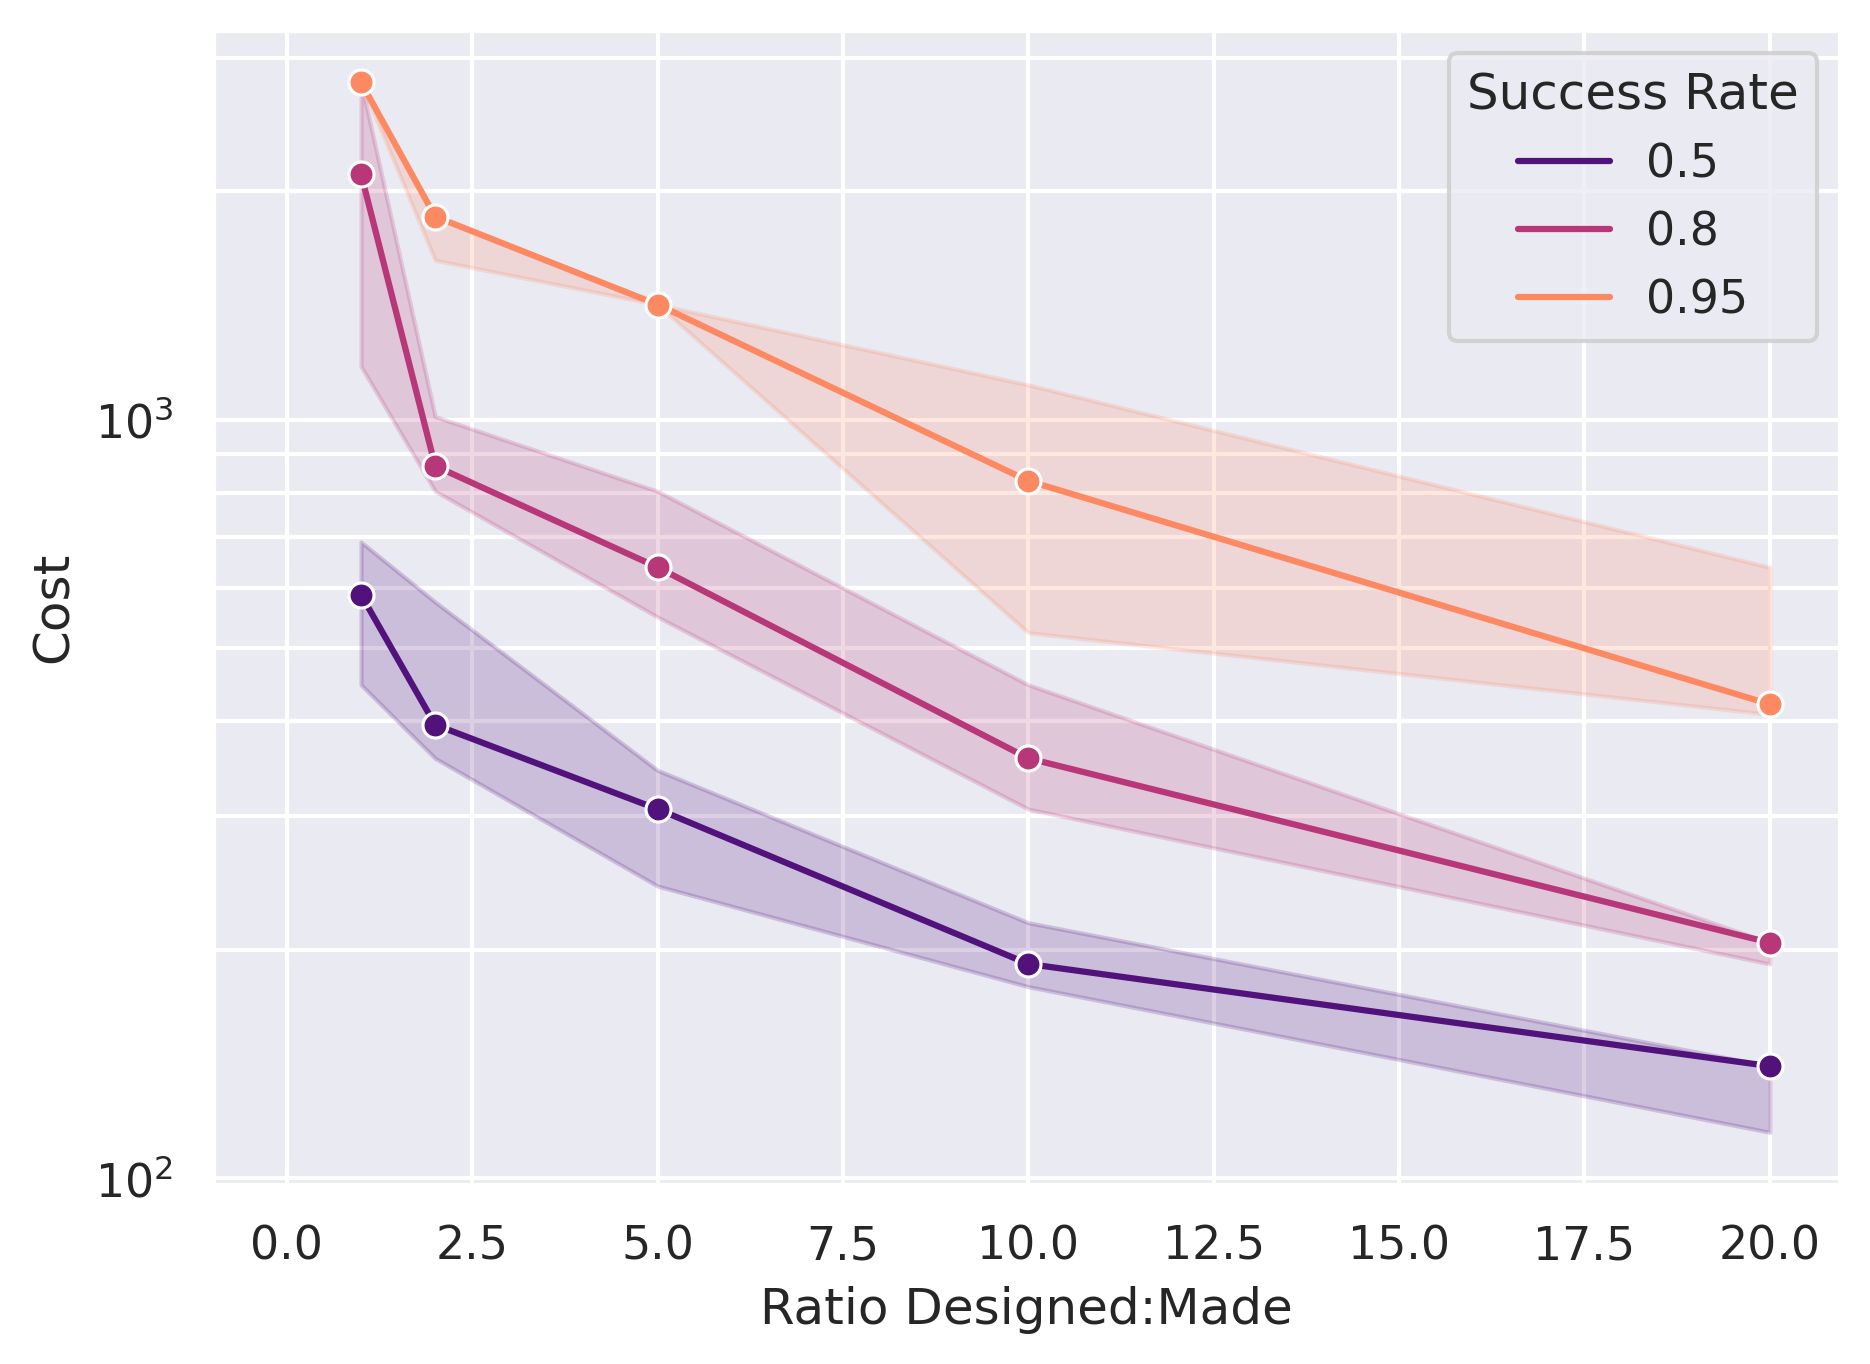

In [705]:
import matplotlib.ticker as ticker
plt.figure(figsize=(7, 5), dpi=300)

success_rates = [0.5, 0.8, 0.95]
prob = closest_success_rate(subset, success_rates, 'KM_estimate', 'score_ratio')
prob_low = closest_success_rate(subset, success_rates, 'KM_estimate_lower_0.68', 'score_ratio')
prob_high = closest_success_rate(subset, success_rates, 'KM_estimate_upper_0.68', 'score_ratio')

g = sns.lineplot(
    prob,
    x=measure,
    y='timeline',
    marker='o',
    hue='Success Rate',
    ci=False,
    palette=sns.color_palette('magma', len(prob['Success Rate'].unique())),
)

colors = sns.color_palette('magma', len(prob['Success Rate'].unique()))
for idx, success_rate in enumerate(success_rates):
    g.fill_between(
        prob.query(f'`Success Rate` == {success_rate}')['score_ratio'],
        prob_low.query(f'`Success Rate` == {success_rate}')['timeline'],
        prob_high.query(f'`Success Rate` == {success_rate}')['timeline'],
        alpha=0.2,
        color=colors[idx]
    )

# iterate through each axes
g.grid(True, which="both", axis='y')
locmin = ticker.LogLocator(
    base=10,
    subs=np.arange(0.1, 1, 0.1),
    numticks=10
)
g.yaxis.set_minor_locator(locmin)
plt.yscale('log')
# g.set_xticks([0, 5, 10, 15, 20, 25, ])
# Ensure the y-axis starts at 0
# g.set_ylim(bottom=80)
plt.xlim(-1)
plt.xlabel('Ratio Designed:Made')
plt.ylabel(f'Cost')
# plt.title(f'Expected cost versus ratio designed:made')

## Estimating the value per molecule scored

In [735]:
medians

,score_ratio,number_scored,number_made,total_cost
0,1,857.0,633.0,63300.0
1,2,611.0,353.5,35350.0
2,5,1557.5,441.5,44150.0
3,10,1414.0,206.0,20600.0
4,20,2057.0,141.0,14100.0
5,40,3105.5,98.5,9850.0


In [742]:
# Function to perform bootstrap sampling within each group
def bootstrap_sample(group):
    return group.sample(n=len(group), replace=True)

bootstraps = []
for idx in tqdm(range(10_000)):

    # Apply the bootstrap sampling within each group
    bootstrapped_df = df.groupby('trial', group_keys=False).apply(bootstrap_sample)

    # Compute median for scored and made molecules
    medians = (
        bootstrapped_df
        .groupby(measure)
        .agg({'number_scored': 'median', 'number_made': 'median'})
        .reset_index()
    ).copy()
    
    # Compute relevant statistics
    medians['total_cost'] = medians['number_made'] * 100
    expected_cost = medians.query(f'{measure} == 1')['total_cost'].item()
    medians['savings'] = expected_cost - medians['total_cost']
    medians['Breakeven ($)'] = medians['savings'] / medians['number_scored']

    # Append
    medians['bootstrap'] = idx
    bootstraps.append(medians)

bootstraps_raw = pd.concat(bootstraps)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [740]:
# Function to compute the confidence interval
def lower_bound(data, confidence_level=0.95):
    lower_percentile = (1 - confidence_level) / 2
    lower_bound = np.percentile(data, lower_percentile * 100)
    return lower_bound

def upper_bound(data, confidence_level=0.95):
    upper_percentile = 1 - (1 - confidence_level) / 2
    upper_bound = np.percentile(data, upper_percentile * 100)
    return upper_bound

bootstraps = (
    bootstraps_raw
    .groupby(measure, as_index=False)
    .agg({
        'Breakeven ($)': ['mean', lower_bound, upper_bound],
    })
)

bootstraps.columns = list(map(''.join, bootstraps.columns.values))

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'score_ratio')

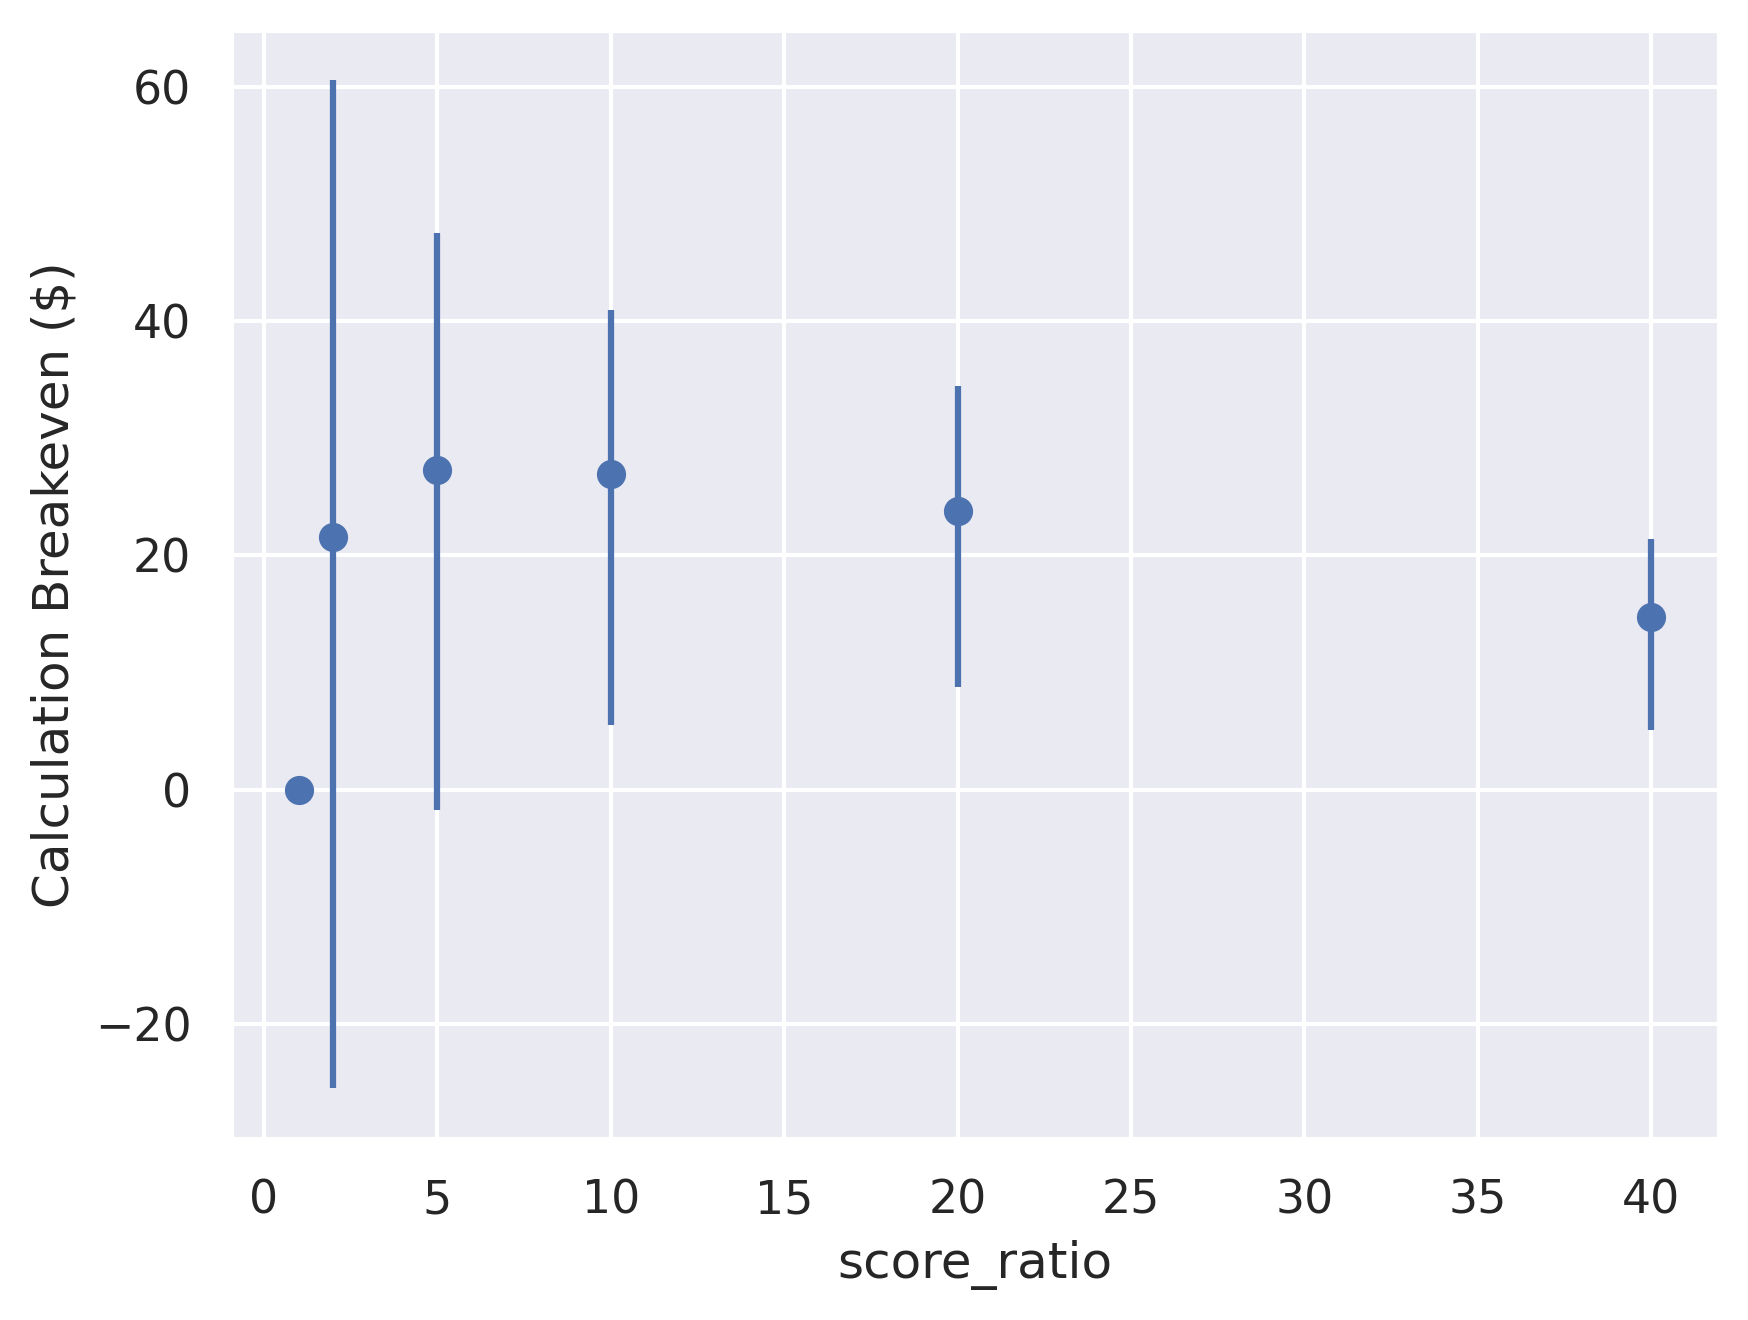

In [741]:
plt.figure(dpi=300)
g = sns.scatterplot(
    bootstraps,
    x=measure,
    y='Breakeven ($)mean',
    marker='o'
)

plt.errorbar(
    x=bootstraps[measure],
    y=bootstraps['Breakeven ($)mean'],
    yerr=[
        abs(bootstraps['Breakeven ($)mean']
         - bootstraps['Breakeven ($)upper_bound']),
        abs(bootstraps['Breakeven ($)mean']
         - bootstraps['Breakeven ($)lower_bound']),
    ],
    fmt='o',
    capsize=5,
    capthick=0,
    elinewidth=1.5,
)

plt.ylabel('Calculation Breakeven ($)')
plt.xlabel(measure)